
Statistiques descriptives de l'impulsion totale :
count    7304.000000
mean       12.669874
std        21.408346
min         0.000000
25%         0.698411
50%         2.812127
75%        14.632143
max       137.222680
Name: p, dtype: float64


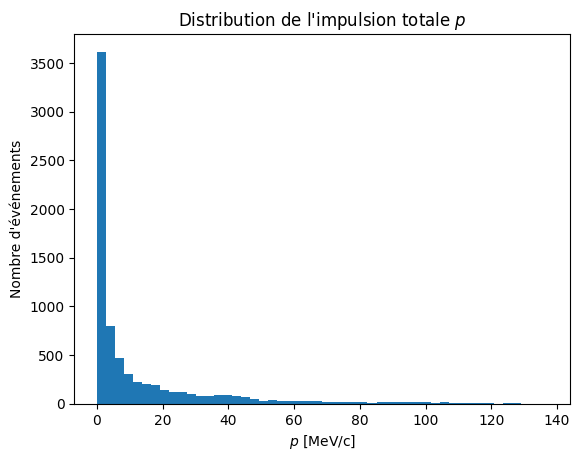

In [5]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MASS_MEV    = 0.511     # mc^2 en MeV (électron)


# Chargement du fichier ROOT et lecture de l'arbre 'momenta'
file = uproot.open("./build/output.root")
tree = file["momenta"]

# Extraction des colonnes dans un DataFrame Pandas
df = tree.arrays(["eventID", "px", "py", "pz"], library="pd")

# Calcul de l'impulsion totale p
df["p"] = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)

# Statistiques descriptives pour l'impulsion totale
print("\nStatistiques descriptives de l'impulsion totale :")
print(df["p"].describe())

# Histogramme de l'impulsion totale
plt.figure()
plt.hist(df["p"], bins=50)
plt.title("Distribution de l'impulsion totale $p$")
plt.xlabel("$p$ [MeV/c]")
plt.ylabel("Nombre d'événements")
plt.show()


In [6]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 1) Open the single-run ROOT file
file = uproot.open("./build/output.root")

# 2) Access the two ntuples
hits_tree    = file["Hits"]
runData_tree = file["RunData"]

# 3) Load columns from the Hits TTree
charges       = hits_tree["fCharge"].array(library="np")
masses = hits_tree["fMass"].array(library="np")
energies      = hits_tree["fEnergy"].array(library="np")
particle_names = hits_tree["ParticleName"].array(library="np")  # Ajouté

# 4) Apply masks to identify particle types
#mask_photons    = (charges == 0) & (masses==0)
#mask_electrons  = (charges == -1)
#mask_positrons  = (charges == 1) 
#mask_neutrons   = (charges == 0) & (masses!=0) # charge = 0 mais on filtre par nom

# 4) Apply masks to identify particle types
mask_photons    = (particle_names == "gamma")
mask_electrons  = (particle_names == "e-")
mask_positrons  = (particle_names == "e+")
mask_neutrons   = (particle_names == "neutron")
mask_muons   = (particle_names == "nu_mu")


# 5) Extract energies
photon_energies   = energies[mask_photons]
electron_energies = energies[mask_electrons]
positron_energies = energies[mask_positrons]
neutron_energies  = energies[mask_neutrons]
muons_energies  = energies[mask_muons]

# 6) Count particles
count_photons    = np.sum(mask_photons)
count_electrons  = np.sum(mask_electrons)
count_positrons  = np.sum(mask_positrons)
count_neutrons   = np.sum(mask_neutrons)
count_muons      = np.sum(mask_muons)
total_hits       = len(charges)

# 7) Print summary
print(f"Total hits        : {total_hits}")
print(f"Photon hits       : {count_photons}")
print(f"Electron hits     : {count_electrons}")
print(f"Positron hits     : {count_positrons}")
print(f"Neutron hits      : {count_neutrons}")
print(f"Muons hits      : {count_muons}")

# 8) Plot energy distributions
def plot_energy(energies, particle, bins=100):
    plt.hist(energies, bins=bins, histtype="stepfilled", alpha=0.7)
    plt.xlabel(f"{particle} energy (MeV)")
    plt.ylabel("Counts")
    plt.title(f"{particle} Energy Distribution")
    plt.grid(True)
    plt.yscale("log")
    plt.show()

plot_energy(photon_energies, "Photon")
plot_energy(electron_energies, "Electron")
plot_energy(positron_energies, "Positron")
plot_energy(neutron_energies, "Neutron")
plot_energy(muons_energies, "Muons")

# 9) Beam charge (C) and slope
beam_charge_coulombs = runData_tree["beamChargeC"].array(library="np")[0]
print(f"Beam charge  = {beam_charge_coulombs:.3e} C")

if beam_charge_coulombs != 0:
    slope_photons = count_photons / beam_charge_coulombs
    slope_neutrons = count_neutrons / beam_charge_coulombs
else:
    slope_photons = 0.0
    slope_neutrons = 0.0

print(f"Slope (photons per coulomb) = {slope_photons:.3e}")
print(f"Slope (neutrons per coulomb) = {slope_neutrons:.3e}")

# 10) Plot number of photons & neutrons vs. beam charge
x_line = np.linspace(0, beam_charge_coulombs, 10)
y_photons = slope_photons * x_line
y_neutrons = slope_neutrons * x_line

#plt.plot(x_line * 1e12, y_photons, label="Photons", color="blue")
plt.plot(x_line * 1e12, y_neutrons, label="Neutrons", color="green")
plt.xlabel("Beam charge (pC)")
plt.ylabel("Number of particles")
plt.title("Number of Particles vs. Beam Charge")
plt.legend()
plt.grid(True)
plt.show()

# 11) Save to pickle
results_dict = {
    "total_hits"          : total_hits,
    "count_photons"       : count_photons,
    "count_electrons"     : count_electrons,
    "count_positrons"     : count_positrons,
    "count_neutrons"      : count_neutrons,
    "photon_energies"     : photon_energies,
    "electron_energies"   : electron_energies,
    "positron_energies"   : positron_energies,
    "neutron_energies"    : neutron_energies,
    "beam_charge_coulombs": beam_charge_coulombs,
    "slope_photons"       : slope_photons,
    "slope_neutrons"      : slope_neutrons
}

with open("results.pkl", "wb") as f:
    pickle.dump(results_dict, f)


KeyInFileError: not found: 'Hits' (with any cycle number)

    Available keys: 'momenta;1'

in file ./build/output.root

In [ ]:
# Impulsion et énergie cinétique
p = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)   # MeV/c
ratio = p.to_numpy() / MASS_MEV
T = MASS_MEV * (np.sqrt(1.0 + ratio**2) - 1.0)         # MeV
E_THRESHOLD = 50.0       # repère visuel, en MeV
# Stats rapides
print("\nStatistiques T [MeV]:")
print(pd.Series(T).describe())

# Histogramme non pondéré
plt.figure(figsize=(8,5))
plt.hist(T, bins=100, edgecolor="black", alpha=0.9, log=True)
plt.axvline(E_THRESHOLD, ls="--", alpha=0.7, label=f"Seuil {E_THRESHOLD} MeV")
plt.xlabel("Énergie cinétique T [MeV]")
plt.ylabel("Nombre d'événements")
plt.title("Distribution de l'énergie cinétique (Geant4)")
plt.grid(alpha=0.3, ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# Sanity checks
print(f"Total (somme des bins) ~ len(T) : {len(T)}")
frac_over = (T > E_THRESHOLD).mean() * 100
print(f"Part des événements avec T > {E_THRESHOLD} MeV : {frac_over:.2f}%")

In [ ]:
# Histogramme de l'impulsion totale
plt.figure()
plt.hist(df["px"], bins=50)
plt.title("Distribution de l'impulsion $p_x$")
plt.xlabel("$p$ [MeV/c]")
plt.ylabel("Nombre d'événements")
plt.show()

print("\nStatistiques descriptives de l'impulsion :")
print(df["px"].describe())


In [ ]:
# Histogramme de l'impulsion totale
plt.figure()
plt.hist(df["py"], bins=50)
plt.title("Distribution de l'impulsion $p_y$")
plt.xlabel("$p$ [MeV/c]")
plt.ylabel("Nombre d'événements")
plt.show()

print("\nStatistiques descriptives de l'impulsion :")
print(df["py"].describe())

In [ ]:
# Histogramme de l'impulsion totale
plt.figure()
plt.hist(df["pz"], bins=50)
plt.title("Distribution de l'impulsion $p_z$")
plt.xlabel("$p$ [MeV/c]")
plt.ylabel("Nombre d'événements")
plt.show()

print("\nStatistiques descriptives de l'impulsion :")
print(df["pz"].describe())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Histogramme 2D px vs pz en échelle log
plt.figure(figsize=(8, 6))
hist = plt.hist2d(
    df["px"], df["pz"],
    bins=100,
    cmap="viridis",
    norm=LogNorm()          # Échelle logarithmique
)
plt.colorbar(hist[3], label="Nombre d'événements (log)")
plt.title("Fichier output Geant4 $p_x$ vs $p_z$")
plt.xlabel("$p_x$ [MeV/c]")
plt.ylabel("$p_z$ [MeV/c]")
plt.show()


In [ ]:
"""import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# ─── 1) Chargement du fichier ROOT et lecture de l'arbre 'momenta' ─────────────
file = uproot.open("./build/output.root")
tree = file["momenta"]

# Extraction des colonnes dans un DataFrame Pandas
df = tree.arrays(["eventID", "px", "py", "pz"], library="pd")

# ─── 2) Calcul de l'impulsion totale p ────────────────────────────────────────
df["p"] = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)

# ─── 3) Calcul de l'énergie cinétique en MeV ───────────────────────────────────
MASS_E_MEV = 0.511    # masse de l'électron en MeV/c²
E_tot = np.sqrt(df["p"]**2 + MASS_E_MEV**2)
df["E_kin"] = E_tot - MASS_E_MEV

# ─── 4) Filtrage énergétique ──────────────────────────────────────────────────
E_THRESHOLD = 1.0  # MeV
df_filtered = df[df["E_kin"] > E_THRESHOLD]

print(f"Nombre total de particules : {len(df)}")
print(f"Nombre après filtrage (E > {E_THRESHOLD} MeV) : {len(df_filtered)}")

# ─── 5) Histogramme 2D px vs pz en échelle log ────────────────────────────────
plt.figure(figsize=(8, 6))
hist = plt.hist2d(
    df_filtered["px"], df_filtered["pz"],
    bins=100,
    cmap="viridis",
    norm=LogNorm(vmin=1)  # Échelle logarithmique
)
plt.colorbar(hist[3], label=f"Nombre d'événements (E > {E_THRESHOLD} MeV)")
plt.title("Fichier output Geant4 $p_x$ vs $p_z$ filtré en énergie")
plt.xlabel("$p_x$ [MeV/c]")
plt.ylabel("$p_z$ [MeV/c]")
plt.show()"""
